In [1]:
import pandas as pd
from datetime import date, timedelta

In [2]:
def read(name: str):
    return pd.read_csv(f'./данные для исследований/{name}', sep=';').drop(columns=['dataset'])

In [3]:
ort = read('Оборот розничной торговли, Россия — Диаграмма.csv')
ipc = read('Индекс потребительских цен, Россия — Диаграмма.csv')
zp = read('Заработная плата, Россия — Диаграмма.csv')
zn = read('Занятость населения, Россия — Диаграмма.csv')
imp = read('Ежемесячный импорт, млн долларов США, Россия — Диаграмма.csv')
ov = read('Объем вкладов (депозитов).csv')
ibk = read('Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия — Диаграмма.csv')
ni = read('Новостной идекс ЦБ, Россия — Диаграмма.csv')

у новостного индекса на начало месяца

In [4]:
ni.date = pd.to_datetime(ni.date, format='%d.%m.%Y').dt.date
ni.head(1)

,date,"Новостной идекс ЦБ, Россия"
0,2004-02-01,1.283101


In [5]:
df = (ort.merge(ipc, on='date')
 .merge(zp, on='date')
 .merge(zn, on='date')
 .merge(imp, on='date')
 .merge(ibk, on='date')
 .merge(ov, on='date')
)

In [6]:
df

,date,"Оборот розничной торговли, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года (в сопоставимых ценах)|Всего","Индекс потребительских цен, Россия: в % к предыдущему месяцу","Заработная плата, Россия: ежемесячные данные|Реальная начисленная заработная плата работников организаций|в % к соответствующему периоду предыдущего года","Занятость населения, Россия: ежемесячные данные|Численность официально зарегистрированных безработных в органах службы занятости населения, которые получают пособие по безработице, на конец месяца|тыс. человек","Ежемесячный импорт, млн долларов США, Россия","Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия","Объем вкладов (депозитов) и прочих привлеченных средств физических лиц, Россия: объем вкладов (депозитов) и прочих привлеченных средств физических лиц - всего"
0,31.01.2002,110.2,119.0,115.8,1057,3515,-0.032138,678.5
1,28.02.2002,109.1,117.7,119.5,1127,3818,4.755294,706.2
2,31.03.2002,109.7,116.8,116.6,1147,4450,10.802178,731.6
3,30.04.2002,109.9,116.0,121.3,1147,4903,8.976228,758.0
4,31.05.2002,106.4,115.9,118.3,1094,4480,6.112399,793.1
...,...,...,...,...,...,...,...,...
263,31.12.2023,110.7,107.4,108.5,320,27795,3.004770,41977.5
264,31.01.2024,108.5,107.4,108.5,306,21370,1.989294,44920.9
265,29.02.2024,111.7,107.7,110.8,310,23050,14.562286,44867.1
266,31.03.2024,111.1,107.7,112.9,309,22719,16.508354,46110.7


Увеличим все дни в df на 1, чтобы они перешли с последних чисел месяца на первое

In [7]:
df.date = pd.to_datetime(df.date, format='%d.%m.%Y').apply(lambda x: x + timedelta(days=1)).dt.date

In [8]:
df.head(1)

,date,"Оборот розничной торговли, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года (в сопоставимых ценах)|Всего","Индекс потребительских цен, Россия: в % к предыдущему месяцу","Заработная плата, Россия: ежемесячные данные|Реальная начисленная заработная плата работников организаций|в % к соответствующему периоду предыдущего года","Занятость населения, Россия: ежемесячные данные|Численность официально зарегистрированных безработных в органах службы занятости населения, которые получают пособие по безработице, на конец месяца|тыс. человек","Ежемесячный импорт, млн долларов США, Россия","Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия","Объем вкладов (депозитов) и прочих привлеченных средств физических лиц, Россия: объем вкладов (депозитов) и прочих привлеченных средств физических лиц - всего"
0,2002-02-01,110.2,119.0,115.8,1057,3515,-0.032138,678.5


In [9]:
df = df.merge(ni, on='date')

df = df.rename(columns={
    'Оборот розничной торговли, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года (в сопоставимых ценах)|Всего': 'Оборот розничной торговли',
    'Индекс потребительских цен, Россия: в % к предыдущему месяцу': 'Индекс потребительских цен',
    'Заработная плата, Россия: ежемесячные данные|Реальная начисленная заработная плата работников организаций|в % к соответствующему периоду предыдущего года': 'Заработная плата',
    'Занятость населения, Россия: ежемесячные данные|Численность официально зарегистрированных безработных в органах службы занятости населения, которые получают пособие по безработице, на конец месяца|тыс. человек': 'Занятость населения',
    'Ежемесячный импорт, млн долларов США, Россия': 'Импорт',
    'Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия': 'Индикатор бизнес климата',
    'Объем вкладов (депозитов) и прочих привлеченных средств физических лиц, Россия: объем вкладов (депозитов) и прочих привлеченных средств физических лиц - всего': 'Обьем депозитов'
}
)

In [10]:
df

,date,Оборот розничной торговли,Индекс потребительских цен,Заработная плата,Занятость населения,Импорт,Индикатор бизнес климата,Обьем депозитов,"Новостной идекс ЦБ, Россия"
0,2004-02-01,110.8,111.3,112.1,1287,5363,5.871889,1519.5,1.283101
1,2004-03-01,112.1,110.6,116.7,1316,6334,13.235736,1565.6,1.316614
2,2004-04-01,112.2,110.3,115.7,1310,7506,18.900237,1622.4,1.544784
3,2004-05-01,112.8,110.2,113.9,1299,7473,11.519830,1665.9,1.278623
4,2004-06-01,113.0,110.2,112.8,1246,7122,12.304775,1729.0,1.160094
...,...,...,...,...,...,...,...,...,...
239,2024-01-01,110.7,107.4,108.5,320,27795,3.004770,41977.5,0.906251
240,2024-02-01,108.5,107.4,108.5,306,21370,1.989294,44920.9,0.862086
241,2024-03-01,111.7,107.7,110.8,310,23050,14.562286,44867.1,0.943880
242,2024-04-01,111.1,107.7,112.9,309,22719,16.508354,46110.7,1.428210


In [11]:
df.to_csv('./данные для исследований/оборот_розничной_торговли_факторы.csv')

# 1. Визуальный анализ до обработки

In [12]:
import seaborn as sns

<Axes: >

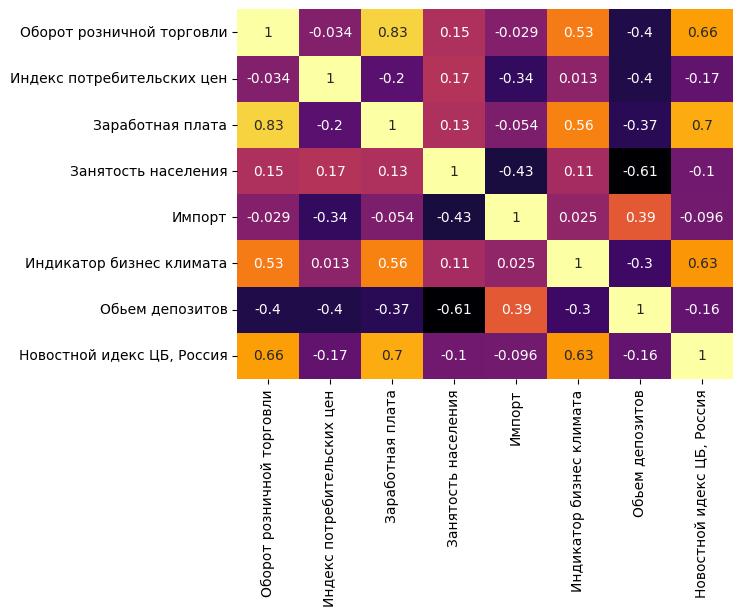

In [13]:
sns.heatmap(df.drop(columns=['date']).corr(), annot=True, cmap='inferno',cbar=False)

# 2. Предобработка. Добавление факторов с лагом. Приведение к процентам к предыдущему году

In [14]:
def percents_to_last_year(column: str):
    # переводит в проценты к соотвтетствующему периоду предыдущего года
    return [None] * 12 + [(df[column].iloc[i] - df[column].iloc[i - 12]) / df[column].iloc[i - 12] for i in range(12, df.shape[0])]

In [15]:
df['Импорт % к соотв. периоду'] = percents_to_last_year('Импорт')
df['Обьем депозитов % к соотв. периоду'] = percents_to_last_year('Обьем депозитов')
df['Занятость населения в %'] = percents_to_last_year('Занятость населения')

In [16]:
features = list(df.drop(columns=['date']).columns)

for column in features:
    df[f'{column}_lag_1'] = df[column].shift(1)
    df[f'{column}_lag_2'] = df[column].shift(2)
    df[f'{column}_lag_3'] = df[column].shift(3)

df['Оборот розничной торговли_lag_1'] = df['Оборот розничной торговли_lag_1'] 
df['Оборот розничной торговли_lag_2'] = df['Оборот розничной торговли_lag_2'] 
df['Оборот розничной торговли_lag_3'] = df['Оборот розничной торговли_lag_3'] 

In [17]:
df

,date,Оборот розничной торговли,Индекс потребительских цен,Заработная плата,Занятость населения,Импорт,Индикатор бизнес климата,Обьем депозитов,"Новостной идекс ЦБ, Россия",Импорт % к соотв. периоду,...,"Новостной идекс ЦБ, Россия_lag_3",Импорт % к соотв. периоду_lag_1,Импорт % к соотв. периоду_lag_2,Импорт % к соотв. периоду_lag_3,Обьем депозитов % к соотв. периоду_lag_1,Обьем депозитов % к соотв. периоду_lag_2,Обьем депозитов % к соотв. периоду_lag_3,Занятость населения в %_lag_1,Занятость населения в %_lag_2,Занятость населения в %_lag_3
0,2004-02-01,110.8,111.3,112.1,1287,5363,5.871889,1519.5,1.283101,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-03-01,112.1,110.6,116.7,1316,6334,13.235736,1565.6,1.316614,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-04-01,112.2,110.3,115.7,1310,7506,18.900237,1622.4,1.544784,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-05-01,112.8,110.2,113.9,1299,7473,11.519830,1665.9,1.278623,NaN,...,1.283101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-06-01,113.0,110.2,112.8,1246,7122,12.304775,1729.0,1.160094,NaN,...,1.316614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2024-01-01,110.7,107.4,108.5,320,27795,3.004770,41977.5,0.906251,-0.065212,...,0.425872,-0.076051,-0.070734,0.048984,0.240957,0.233461,0.196440,-0.215539,-0.260341,-0.259091
240,2024-02-01,108.5,107.4,108.5,306,21370,1.989294,44920.9,0.862086,-0.112873,...,0.848450,-0.065212,-0.076051,-0.070734,0.250685,0.240957,0.233461,-0.225182,-0.215539,-0.260341
241,2024-03-01,111.7,107.7,110.8,310,23050,14.562286,44867.1,0.943880,0.023535,...,0.460260,-0.112873,-0.065212,-0.076051,0.226703,0.250685,0.240957,-0.238806,-0.225182,-0.215539
242,2024-04-01,111.1,107.7,112.9,309,22719,16.508354,46110.7,1.428210,-0.187650,...,0.906251,0.023535,-0.112873,-0.065212,0.260946,0.226703,0.250685,-0.230769,-0.238806,-0.225182


In [18]:
(df.drop(columns=['date'])
 .corr()[['Оборот розничной торговли']]
 .sort_values(by='Оборот розничной торговли'))

,Оборот розничной торговли
Обьем депозитов_lag_1,-0.405958
Обьем депозитов_lag_2,-0.405699
Обьем депозитов,-0.404998
Обьем депозитов_lag_3,-0.404463
Занятость населения в %,-0.262715
Занятость населения в %_lag_1,-0.191627
Занятость населения в %_lag_2,-0.142801
Занятость населения в %_lag_3,-0.110180
Индекс потребительских цен_lag_3,-0.091355
Импорт_lag_3,-0.090908


In [19]:
features = [
    'Оборот розничной торговли_lag_1',
    'Заработная плата',
    'Новостной идекс ЦБ, Россия_lag_1',
    'Импорт % к соотв. периоду_lag_1',
    'Индикатор бизнес климата_lag_1',
    'Занятость населения в %',
    'Обьем депозитов'
]

goal = ['Оборот розничной торговли']

<Axes: >

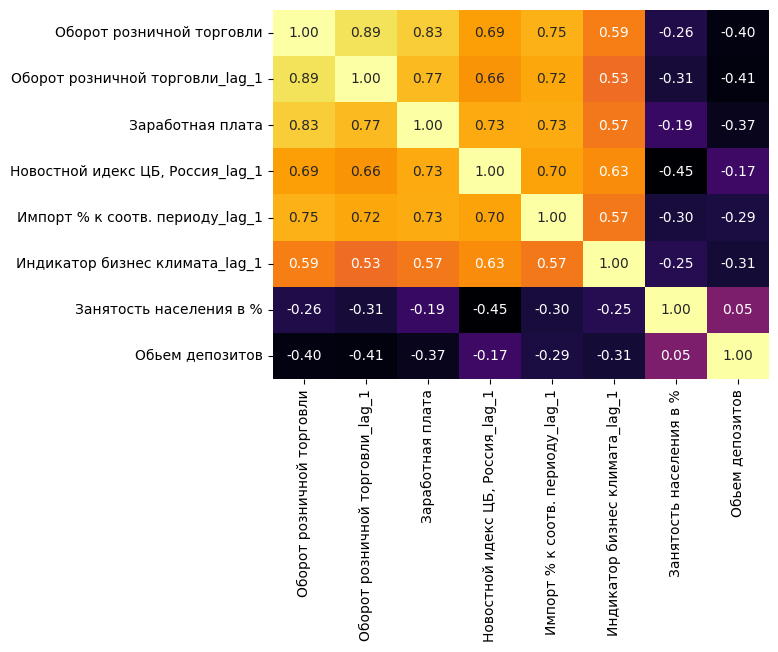

In [20]:
sns.heatmap(
    df[goal + features].corr(),
    fmt=".2f",
    annot=True,
    cmap='inferno',
    cbar=False
)

все между собой коррелирует, надо выделить главную компоненту

# 3. Визуализация связи признаков и оборота розничной торговли

In [21]:
import matplotlib.pyplot as plt

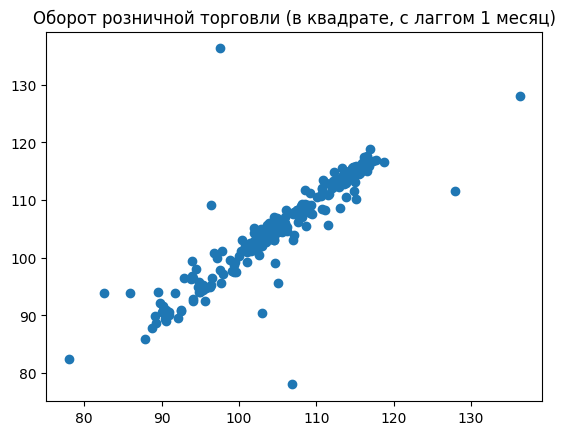

In [22]:
plt.title('Оборот розничной торговли (в квадрате, с лаггом 1 месяц)')
plt.scatter(df['Оборот розничной торговли_lag_1'], df['Оборот розничной торговли'])

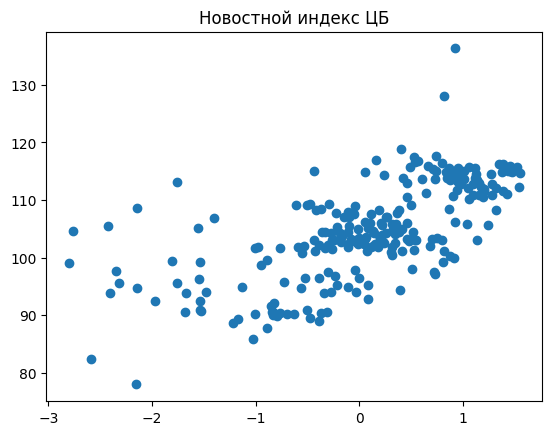

In [23]:
plt.title('Новостной индекс ЦБ')
plt.scatter(df['Новостной идекс ЦБ, Россия'], df['Оборот розничной торговли'])

Text(0, 0.5, 'Оборот розничной торговли')

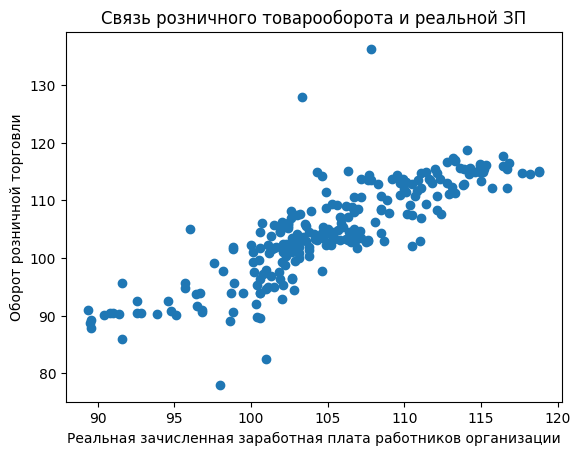

In [24]:
plt.title('Связь розничного товарооборота и реальной ЗП')
plt.scatter(df['Заработная плата'], df['Оборот розничной торговли'])
plt.xlabel('Реальная зачисленная заработная плата работников организации')
plt.ylabel('Оборот розничной торговли')

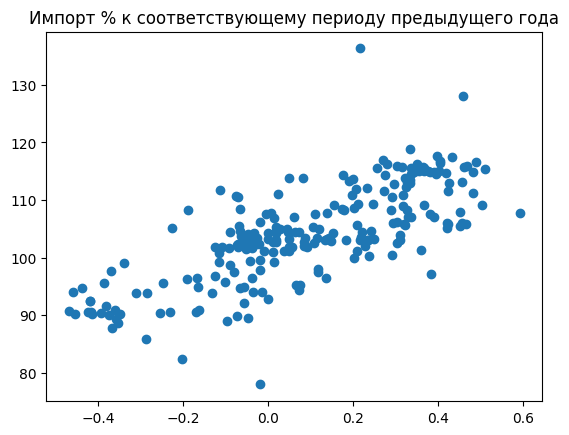

In [25]:
plt.title('Импорт % к соответствующему периоду предыдущего года')
plt.scatter(df['Импорт % к соотв. периоду_lag_1'], df['Оборот розничной торговли'])

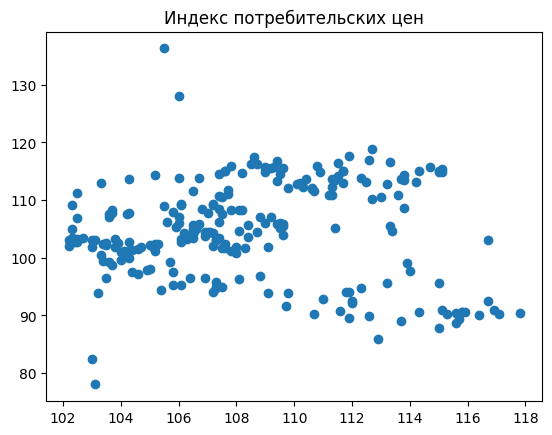

In [26]:
plt.title('Индекс потребительских цен')
plt.scatter(df['Индекс потребительских цен'], df['Оборот розничной торговли'])

In [27]:
df.columns

Index(['date', 'Оборот розничной торговли', 'Индекс потребительских цен',
       'Заработная плата', 'Занятость населения', 'Импорт',
       'Индикатор бизнес климата', 'Обьем депозитов',
       'Новостной идекс ЦБ, Россия', 'Импорт % к соотв. периоду',
       'Обьем депозитов % к соотв. периоду', 'Занятость населения в %',
       'Оборот розничной торговли_lag_1', 'Оборот розничной торговли_lag_2',
       'Оборот розничной торговли_lag_3', 'Индекс потребительских цен_lag_1',
       'Индекс потребительских цен_lag_2', 'Индекс потребительских цен_lag_3',
       'Заработная плата_lag_1', 'Заработная плата_lag_2',
       'Заработная плата_lag_3', 'Занятость населения_lag_1',
       'Занятость населения_lag_2', 'Занятость населения_lag_3',
       'Импорт_lag_1', 'Импорт_lag_2', 'Импорт_lag_3',
       'Индикатор бизнес климата_lag_1', 'Индикатор бизнес климата_lag_2',
       'Индикатор бизнес климата_lag_3', 'Обьем депозитов_lag_1',
       'Обьем депозитов_lag_2', 'Обьем депозитов_lag_3',
 

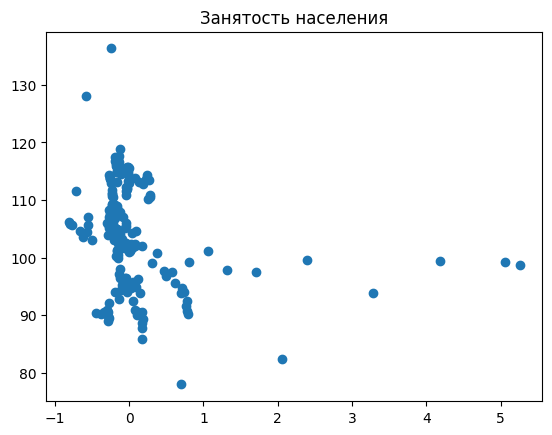

In [28]:
plt.title('Занятость населения')
plt.scatter(df['Занятость населения в %'], df['Оборот розничной торговли'])

# Модель с прогнозом на 1 месяц

In [119]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [193]:
df = df.dropna()

In [307]:
exog_var = [
    'Оборот розничной торговли_lag_2',
    'Заработная плата_lag_1',
    'Новостной идекс ЦБ, Россия_lag_1',
    'Индикатор бизнес климата_lag_1'
]

goal = 'Оборот розничной торговли'


X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df[goal], test_size = 0.125, random_state = 42,shuffle=False)

In [308]:
df[exog_var + [goal]].head(3)

,Оборот розничной торговли_lag_2,Заработная плата_lag_1,"Новостной идекс ЦБ, Россия_lag_1",Индикатор бизнес климата_lag_1,Оборот розничной торговли
15,110.6,109.7,1.098424,19.046348,113.5
16,110.9,107.8,1.133131,9.296435,114.4
17,113.5,107.7,0.949183,11.795654,113.6


In [309]:
model_1 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = model_1.grid_search(
    grid, X_train, y_train,
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)


bestTest = 103.7719812
bestIteration = 5


bestTest = 98.32915656
bestIteration = 5


bestTest = 55.95468397
bestIteration = 5


bestTest = 9.947956214
bestIteration = 5


bestTest = 17.88630876
bestIteration = 2


bestTest = 103.7720798
bestIteration = 5


bestTest = 98.33009519
bestIteration = 5


bestTest = 55.96018454
bestIteration = 5


bestTest = 9.946213705
bestIteration = 5


bestTest = 17.8834758
bestIteration = 2


bestTest = 103.7738445
bestIteration = 5


bestTest = 98.34689935
bestIteration = 5


bestTest = 56.05901731
bestIteration = 5


bestTest = 9.916083718
bestIteration = 5


bestTest = 17.82638774
bestIteration = 5


bestTest = 103.7814693
bestIteration = 5


bestTest = 98.41958185
bestIteration = 5


bestTest = 56.49269843
bestIteration = 5


bestTest = 9.804476423
bestIteration = 5


bestTest = 17.72872942
bestIteration = 4


bestTest = 103.7905459
bestIteration = 5


bestTest = 98.50622596
bestIteration = 5


bestTest = 57.01925585
bestIteration = 5


bestTest = 

In [310]:
res['params']

{'depth': 3, 'learning_rate': 0.1, 'l2_leaf_reg': 0.005, 'iterations': 32}

In [311]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, y_train)

# Качество модели

In [255]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import numpy as np

In [312]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 4)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 4) * 100:0.2f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 4) * 100:0.2f}%')


r2_score: 0.8609
mape train: 1.83%
mape test: 3.52%


Корреляция тестовой выборки и прогноза

In [313]:
train_df = pd.DataFrame({'y_train': y_train, 'train_predict': train_predict})
test_df = pd.DataFrame({'y_test': y_test, 'test_predict': test_predict})

test_df.corr()

,y_test,test_predict
y_test,1.000000,0.918531
test_predict,0.918531,1.000000


In [264]:
train_df.shape

(200, 2)

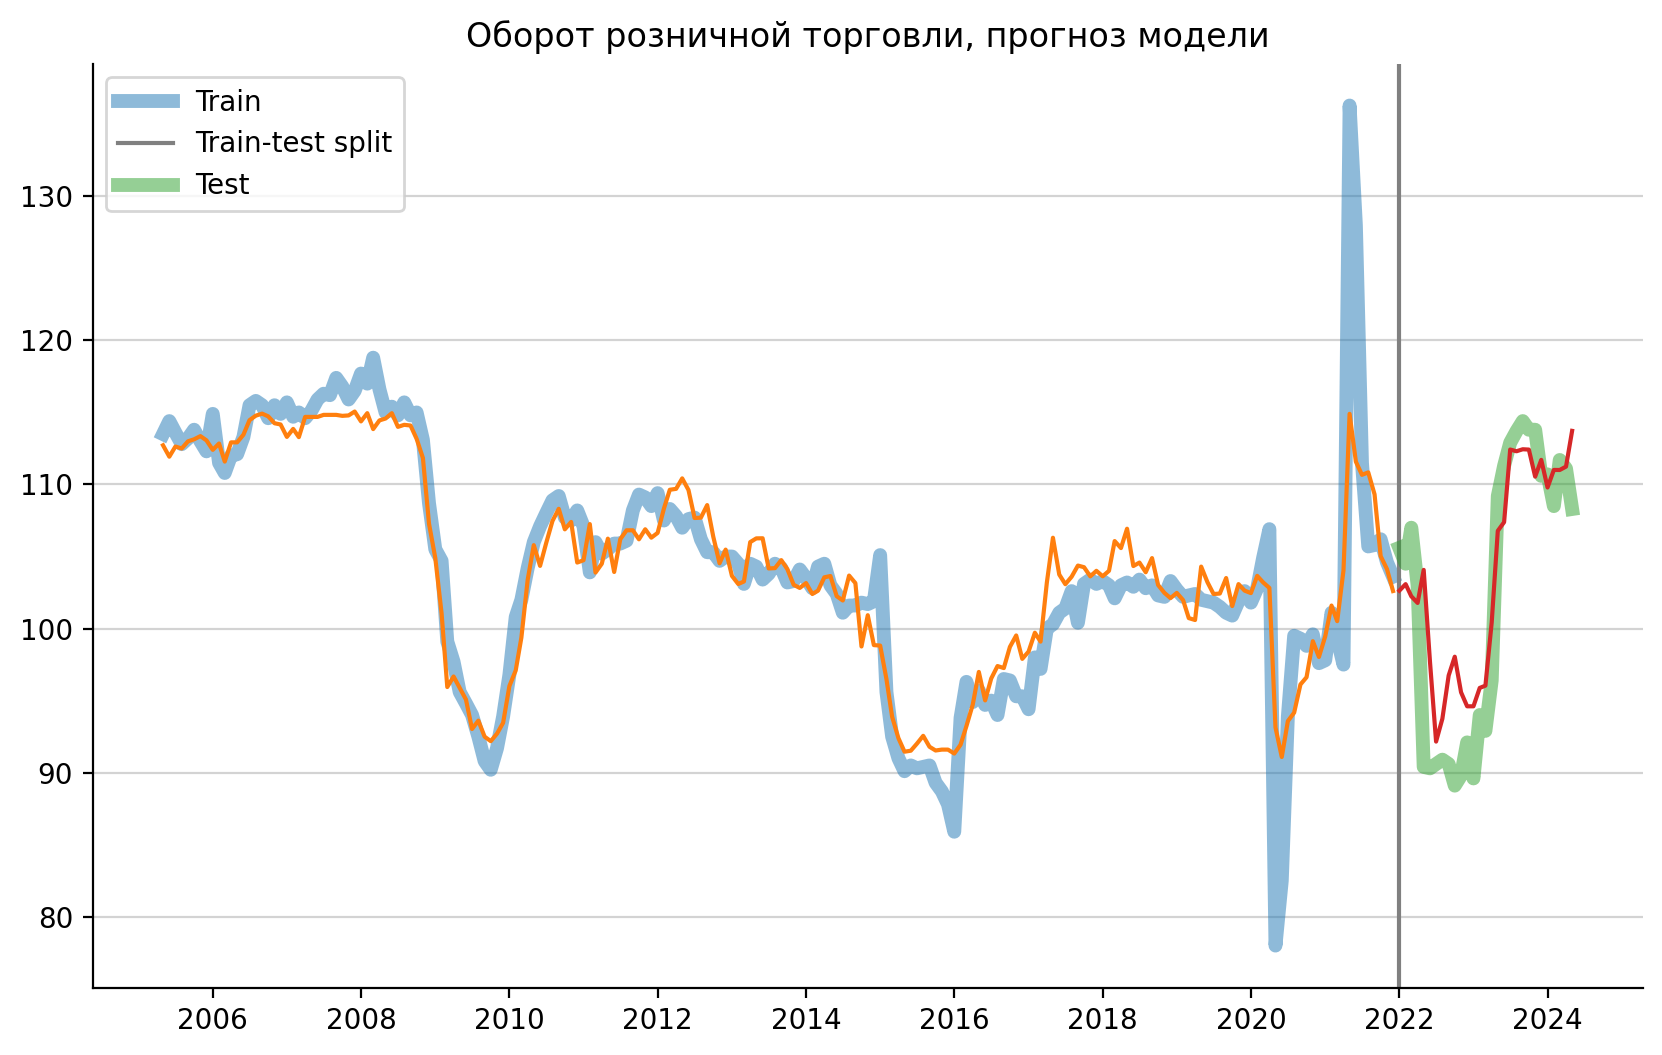

In [314]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

plt.title("Оборот розничной торговли, прогноз модели",fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

plt.plot(df.date[:200], df['Оборот розничной торговли'][:200], label='Train', linewidth=5, alpha=0.5)
plt.plot(df.date[:200], train_df.train_predict)

plt.axvline(df.date.iloc[200], color='grey', label='Train-test split')
plt.plot(df.date[200:], df['Оборот розничной торговли'][200:], label='Test', linewidth=5, alpha=0.5)
plt.plot(df.date[200:], test_df.test_predict)

ax.legend()

# Модель на 2 месяца

In [315]:
exog_var_2 = [
    'Оборот розничной торговли_lag_3',
    'Заработная плата_lag_2',
    'Новостной идекс ЦБ, Россия_lag_2',
    'Индикатор бизнес климата_lag_2'
]

goal = 'Оборот розничной торговли'


X_train, X_test, y_train, y_test = train_test_split(df[exog_var_2], df[goal], test_size = 0.125, random_state = 42,shuffle=False)

model_2 = CatBoostRegressor(**res['params'], verbose = False)
model_2.fit(X_train, y_train)

In [316]:
train_predict = model_2.predict(X_train)
test_predict = model_2.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 4)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 4) * 100:0.2f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 4) * 100:0.2f}%')

r2_score: 0.8126
mape train: 2.03%
mape test: 4.59%


# Модель на 3 месяца

In [317]:
exog_var_3 = [
    'Заработная плата_lag_3',
    'Новостной идекс ЦБ, Россия_lag_3',
    'Индикатор бизнес климата_lag_3'
]

goal = 'Оборот розничной торговли'


X_train, X_test, y_train, y_test = train_test_split(df[exog_var_3], df[goal], test_size = 0.125, random_state = 42,shuffle=False)

model_3 = CatBoostRegressor(**res['params'], verbose = False)
model_3.fit(X_train, y_train)

In [318]:
train_predict = model_3.predict(X_train)
test_predict = model_3.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 4)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 4) * 100:0.2f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 4) * 100:0.2f}%')

r2_score: 0.7479
mape train: 2.74%
mape test: 5.08%


# Прогноз

In [319]:
df.tail(1)

,date,Оборот розничной торговли,Индекс потребительских цен,Заработная плата,Занятость населения,Импорт,Индикатор бизнес климата,Обьем депозитов,"Новостной идекс ЦБ, Россия",Импорт % к соотв. периоду,...,"Новостной идекс ЦБ, Россия_lag_3",Импорт % к соотв. периоду_lag_1,Импорт % к соотв. периоду_lag_2,Импорт % к соотв. периоду_lag_3,Обьем депозитов % к соотв. периоду_lag_1,Обьем депозитов % к соотв. периоду_lag_2,Обьем депозитов % к соотв. периоду_lag_3,Занятость населения в %_lag_1,Занятость населения в %_lag_2,Занятость населения в %_lag_3
243,2024-05-01,108.3,107.8,108.5,286,22689,12.545003,47024.3,1.319478,-0.084235,...,0.862086,-0.18765,0.023535,-0.112873,0.259817,0.260946,0.226703,-0.231343,-0.230769,-0.238806


In [320]:
forecast = pd.DataFrame(columns=['date', 'goal_predict'])
forecast.date = [date(year=2024, month=i + 6, day=1) for i in range(1, 3 + 1)]

In [321]:
forecast.goal_predict.iloc[0] = model.predict(df[exog_var].iloc[-1])
forecast.goal_predict.iloc[1] = model_2.predict(df[exog_var_2].iloc[-1])
forecast.goal_predict.iloc[2] = model_3.predict(df[exog_var_3].iloc[-1])

In [322]:
forecast

,date,goal_predict
0,2024-07-01,113.721895
1,2024-08-01,111.413811
2,2024-09-01,106.512391


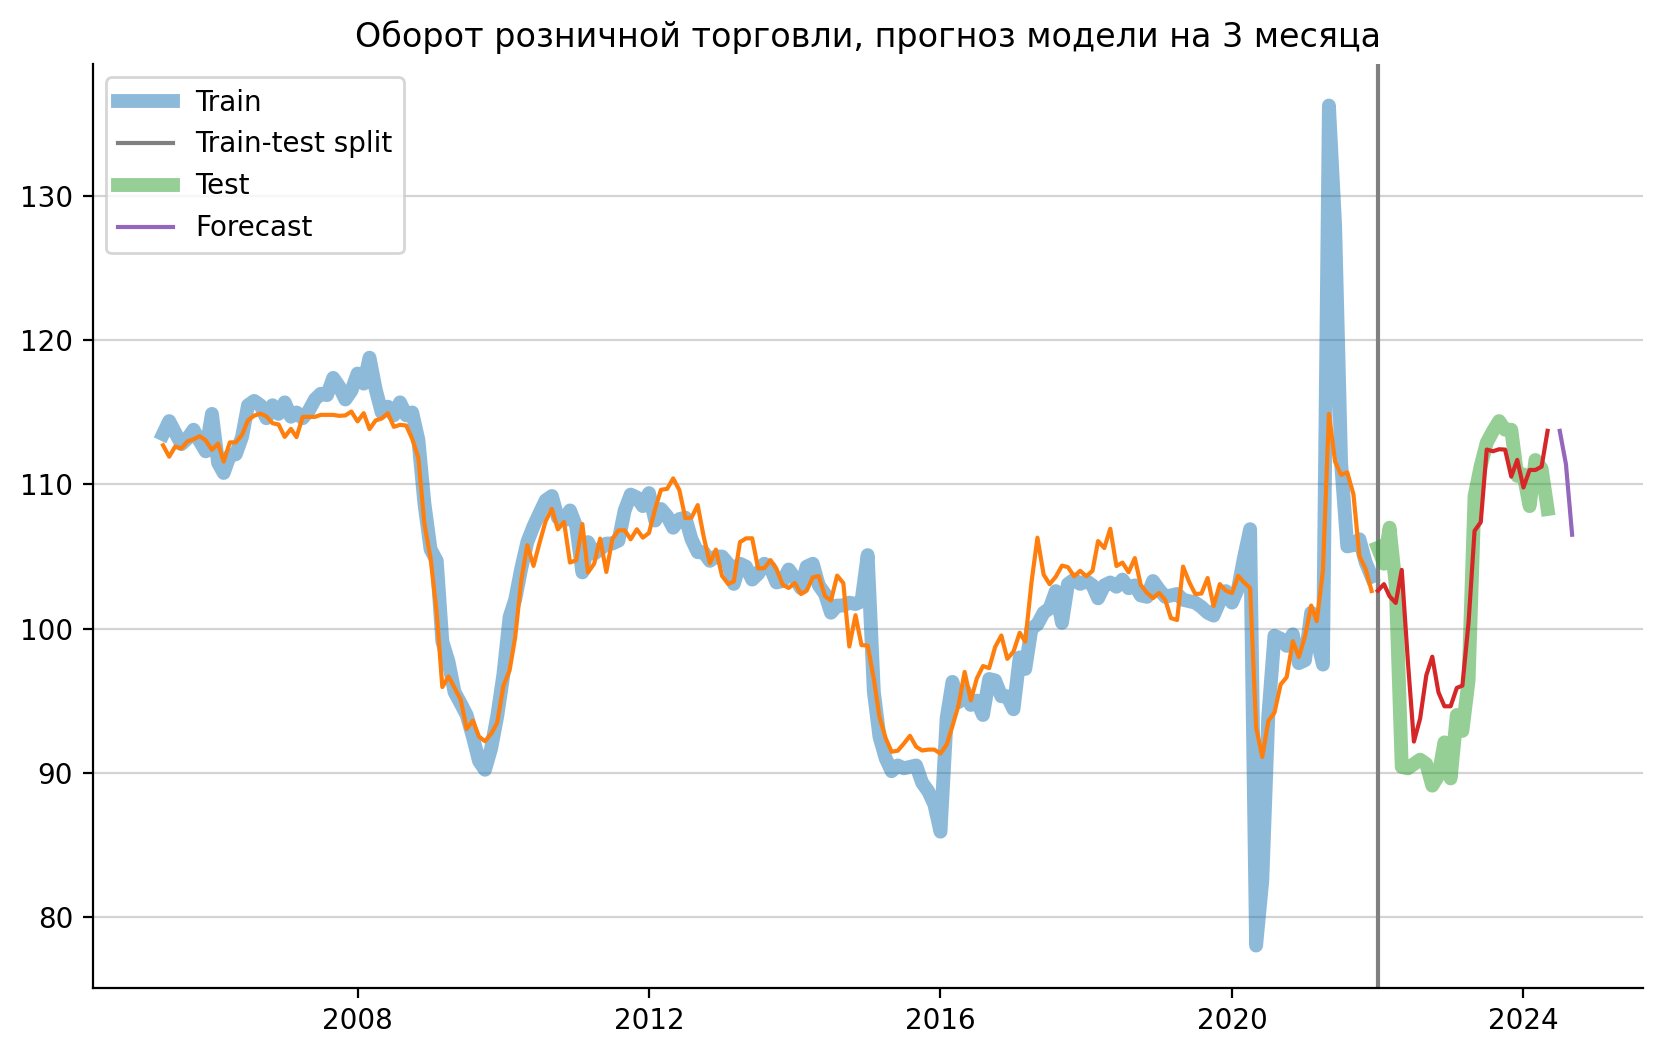

In [323]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

plt.title("Оборот розничной торговли, прогноз модели на 3 месяца",fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

plt.plot(df.date[:200], df['Оборот розничной торговли'][:200], label='Train', linewidth=5, alpha=0.5)
plt.plot(df.date[:200], train_df.train_predict)

plt.axvline(df.date.iloc[200], color='grey', label='Train-test split')
plt.plot(df.date[200:], df['Оборот розничной торговли'][200:], label='Test', linewidth=5, alpha=0.5)
plt.plot(df.date[200:], test_df.test_predict)

ax.plot(forecast.date, forecast.goal_predict, label='Forecast')

ax.legend()